In [1]:
# import pandas

# import modin.pandas as pd
# from modin.config import Engine
# Engine.put("dask") 

In [2]:
import os
import daal4py as d4p
from xgboost import XGBClassifier
import time
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# pio.renderers.default='notebook_connected' 
# intel_pal, color=['#0071C5','#FCBB13'], ['#7AB5E1','#FCE7B2']
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), height=500, width=1000))

In [3]:
# from distributed import Client
# client = Client()

# data = pd.read_csv("dataset.csv")

data = pd.read_csv("50k_dataset.csv")
data = data.drop('Index', axis=1)
print("Total rows in the DataFrame:", len(data))

print(data.dtypes)
display(data.isna().sum())

Total rows in the DataFrame: 5956842
pH                        float64
Iron                      float64
Nitrate                   float64
Chloride                  float64
Lead                      float64
Zinc                      float64
Color                      object
Turbidity                 float64
Fluoride                  float64
Copper                    float64
Odor                      float64
Sulfate                   float64
Conductivity              float64
Chlorine                  float64
Manganese                 float64
Total Dissolved Solids    float64
Source                     object
Water Temperature         float64
Air Temperature           float64
Month                      object
Day                       float64
Time of Day               float64
Target                      int64
dtype: object


pH                        116054
Iron                       39753
Nitrate                   105725
Chloride                  175531
Lead                       26909
Zinc                      156126
Color                       5739
Turbidity                  49815
Fluoride                  189156
Copper                    199402
Odor                      178891
Sulfate                   197418
Conductivity              163861
Chlorine                   57825
Manganese                 109583
Total Dissolved Solids      1670
Source                     88262
Water Temperature         168233
Air Temperature            29728
Month                      95668
Day                        99603
Time of Day               114519
Target                         0
dtype: int64

In [4]:
# handle missing values
start_fill = time.time()
for column in data.columns:
    if data[column].dtype == 'object':
        mode = data[column].mode().iloc[0]
        data[column].fillna(mode, inplace=True)
    else:
        median = data[column].median()
        data[column].fillna(median, inplace=True)

end_fill = time.time()
print("fill missing value took: {:.2f} s".format(end_fill - start_fill))

# drop duplicated rows
data = data.drop_duplicates()

# transform `Color` to number
color_labels, color_unique_values = pd.factorize(data['Color'])
data['Color'] = color_labels
# transform `Source` to number
source_labels, source_unique_values = pd.factorize(data['Source'])
data['Source'] = source_labels

fill missing value took: 3.75 s


In [5]:
display(data.isna().sum())
missing = data.isna().sum().sum()
duplicates = data.duplicated().sum()
print("\nThere are {:,.0f} missing values in the data.".format(missing))
print("There are {:,.0f} duplicate records in the data.".format(duplicates))

display(data.head())

pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Color                     0
Turbidity                 0
Fluoride                  0
Copper                    0
Odor                      0
Sulfate                   0
Conductivity              0
Chlorine                  0
Manganese                 0
Total Dissolved Solids    0
Source                    0
Water Temperature         0
Air Temperature           0
Month                     0
Day                       0
Time of Day               0
Target                    0
dtype: int64


There are 0 missing values in the data.
There are 0 duplicate records in the data.


pH      Iron   Nitrate    Chloride           Lead      Zinc  Color  \
0  8.332988  0.000083  8.605777  122.799772   3.713298e-52  3.434827      0   
1  6.917863  0.000081  3.734167  227.029851   7.849262e-94  1.245317      1   
2  5.443762  0.020106  3.816994  230.995630   5.286616e-76  0.528280      2   
3  7.955339  0.143988  8.224944  178.129940  3.997118e-176  4.027879      3   
4  8.091909  0.002167  9.925788  186.540872  4.171069e-132  3.807511      2   

   Turbidity  Fluoride    Copper  ...  Chlorine     Manganese  \
0   0.022683  0.607283  0.144599  ...  3.708178  2.269945e-15   
1   0.019007  0.622874  0.437835  ...  3.292038  8.024076e-07   
2   0.319956  0.423423  0.431588  ...  3.560224  7.007989e-02   
3   0.166319  0.208454  0.239451  ...  3.516907  2.468295e-02   
4   0.004867  0.222912  0.616574  ...  3.177849  3.296139e-03   

   Total Dissolved Solids  Source  Water Temperature  Air Temperature  \
0              332.118789       0          16.444276        43.493324   
1              284.641984       1          15.348981        71.220586   
2              570.054094       2          11.643467        44.891330   
3              100.043838       3          10.092392        60.843233   
4              168.075545       4          15.249416        69.336671   

      Month   Day  Time of Day Target  
0   January  29.0          4.0      0  
1  November  26.0         16.0      0  
2   January  31.0          8.0      0  
3     April   1.0         21.0      0  
4      June  29.0          7.0      0  

[5 rows x 23 columns]

In [6]:
def display_stats():
    
    """
    Function to display descriptive statistics of numerical variables,
    includes skewness & kurtosis.   
    """
    
    df = data.describe()
    skewness = pd.DataFrame(data.skew(numeric_only=True), columns=['skewness']).T
    kurtosis = pd.DataFrame(data.kurt(numeric_only=True), columns=['kurtosis']).T
    df = pd.concat([df, skewness, kurtosis], axis=0)
    display(df.style.format('{:,.3f}').background_gradient(subset=(df.index[1:],df.columns[:]), cmap='GnBu'))

display_stats()

In [7]:
# show target distribution
target=data['Target'].value_counts(normalize=True)
print(target)

0    0.697833
1    0.302167
Name: Target, dtype: float64


/home/u188545/tmp/ipykernel_3655931/2601483805.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.drop(columns_to_drop, axis=1, inplace=True)


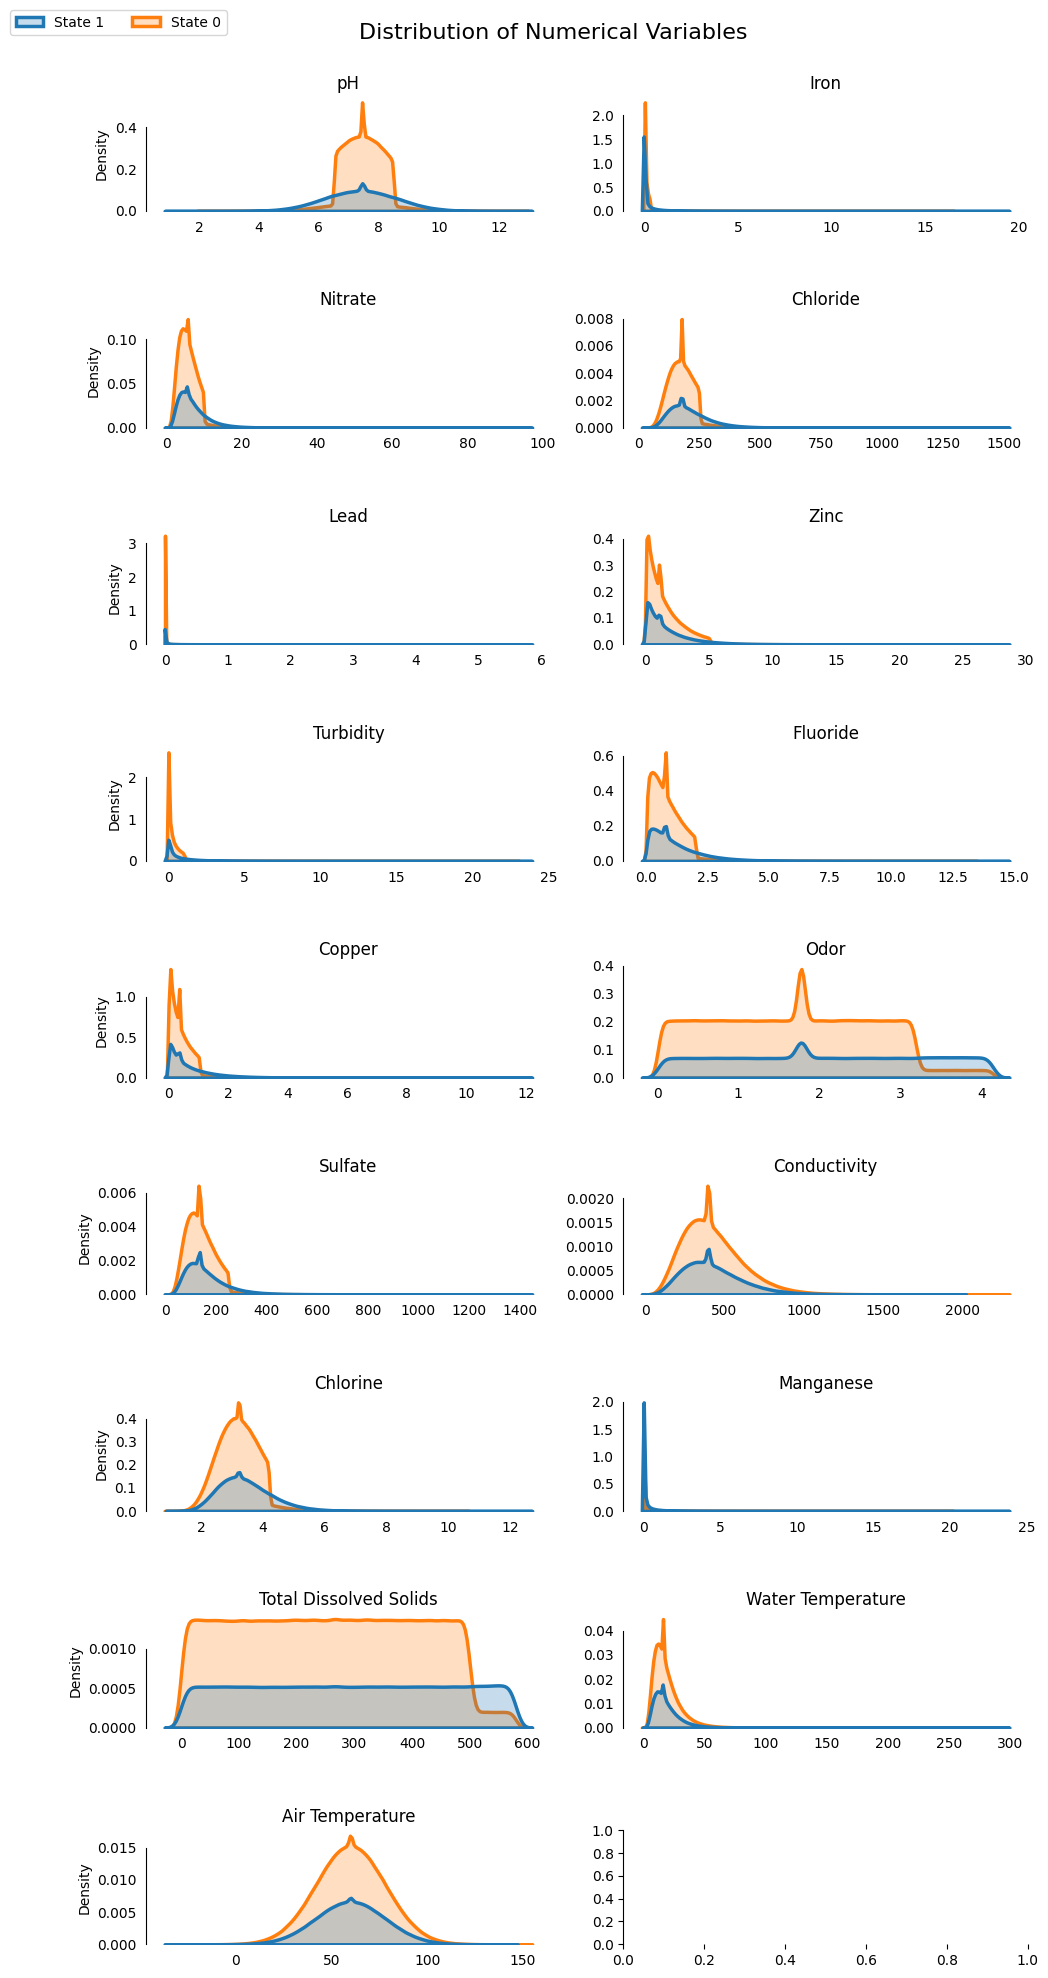

In [8]:
cat_cols,float_cols=[],['Target']
for col in data.columns:
    if data[col].value_counts().count()<10:
        cat_cols.append(col)
    else:
        float_cols.append(col)
        
plot_df=data[float_cols]

# do not display distribution with column `Month` and `Day`
columns_to_drop = ['Month', 'Day']
plot_df.drop([columns_to_drop], axis=1, inplace=True)

fig, ax = plt.subplots(9,2, figsize=(10,20))
fig.suptitle('Distribution of Numerical Variables',fontsize=16)
row=0
col=[0,1]*9

for i, column in enumerate(plot_df.columns[1:-1]):
    if (i!=0)&(i%2==0):
        row+=1
    
    sns.kdeplot(
        x=column, hue='Target', hue_order=[1, 0],
        label=['State 1', 'State 0'], data=plot_df,
        fill=True, linewidth=2.5, legend=False, ax=ax[row, col[i]]
    )
    
    ax[row,col[i]].tick_params(left=False, bottom=False)
    ax[row,col[i]].set(title='\n\n{}'.format(column), xlabel='', ylabel=('Density' if i%2==0 else ''))

handles, _ = ax[0,0].get_legend_handles_labels() 
fig.legend(labels=['State 1','State 0'], handles=reversed(handles), ncol=2, bbox_to_anchor=(0.18, 0.99))
sns.despine(bottom=True, trim=True)
plt.tight_layout()

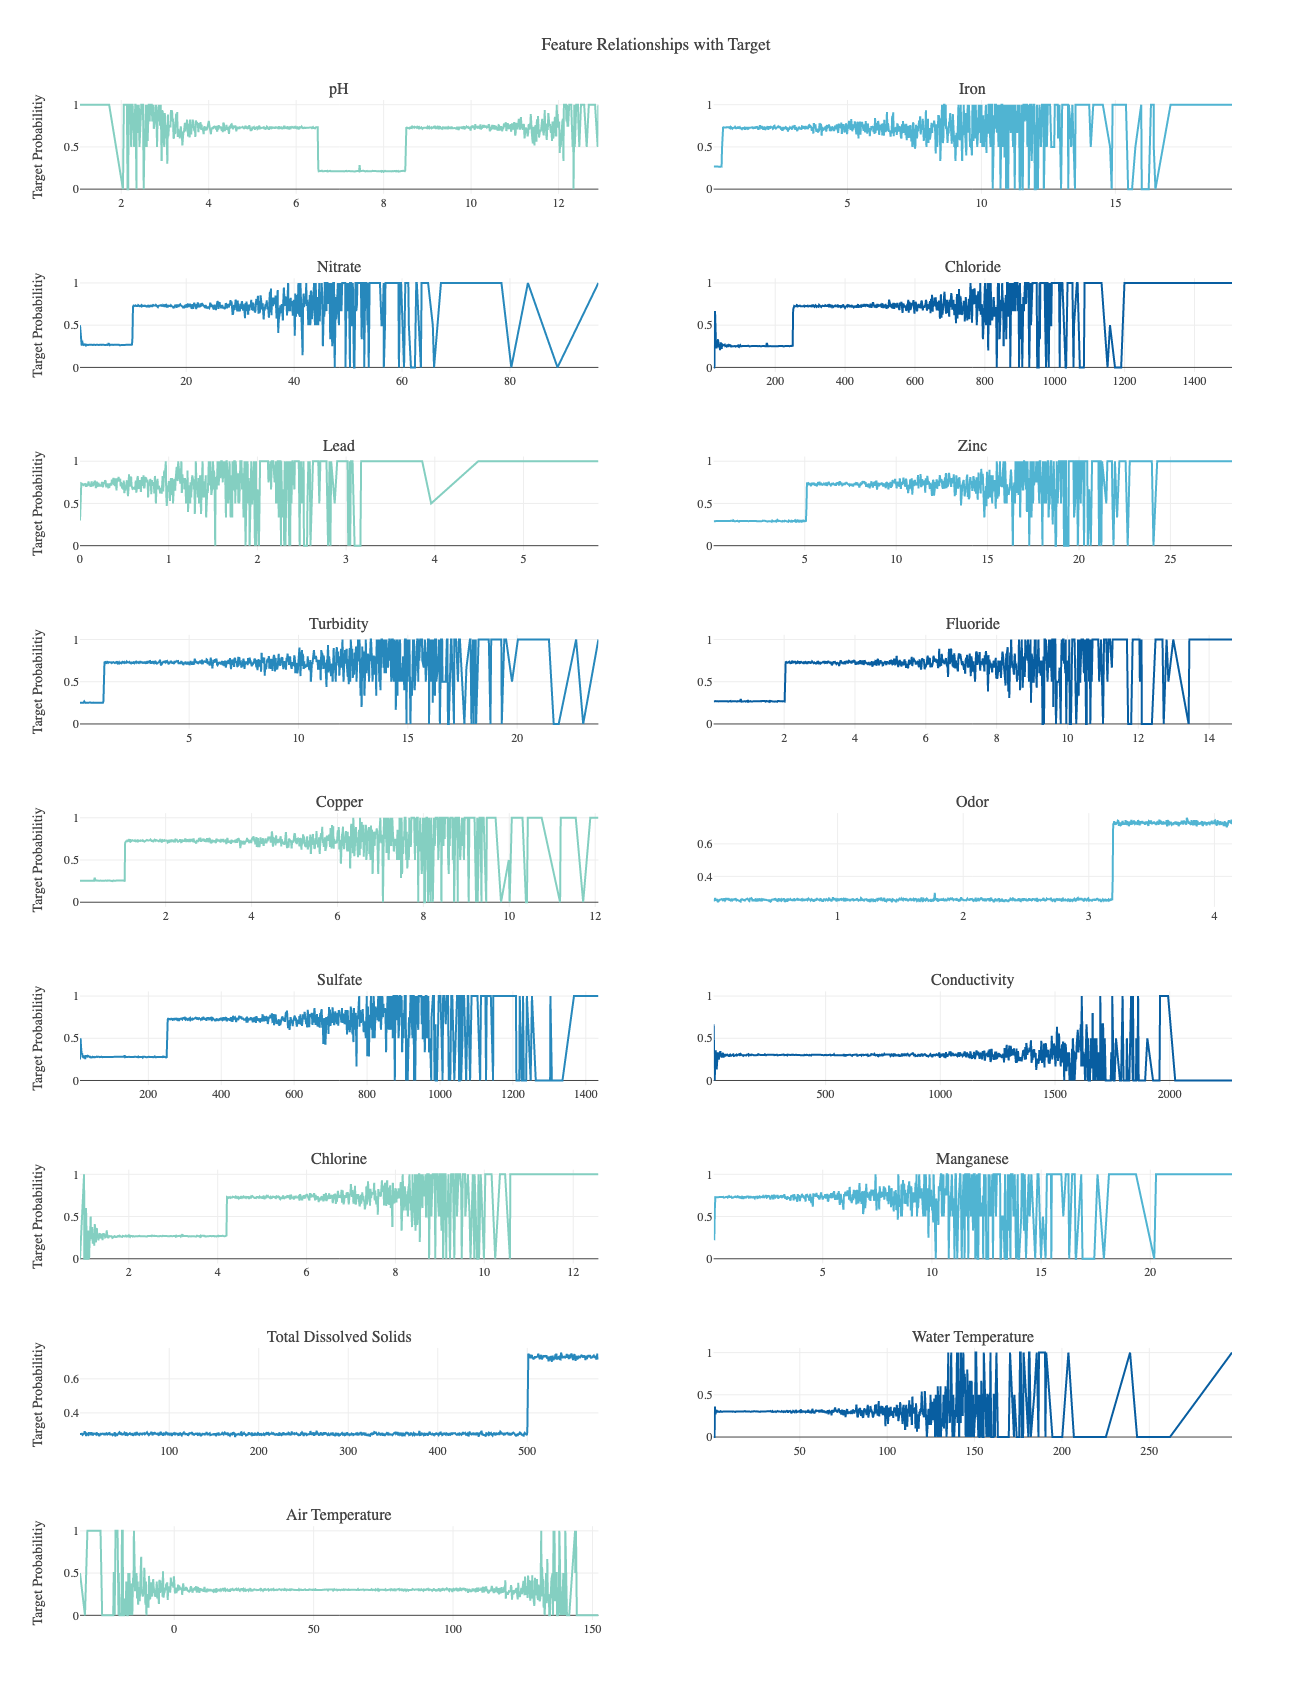

In [9]:
fig=make_subplots(rows=9,cols=2, subplot_titles=float_cols[1:-3])
col=[1,2]*9
row=0
pal=sns.color_palette("GnBu",20).as_hex()[9:][::3]

for i, column in enumerate(data[float_cols].columns[1:-3]):
    if i%2 == 0:
        row += 1
    df = pd.concat([data[column], data['Target']], axis=1)

    df['bins'] = pd.cut(df[column], 1000)
    df['mean'] = df.bins.apply(lambda x: x.mid)

    df = df.groupby('mean')[[column,'Target']].transform('mean')
    df = df.drop_duplicates(subset=[column]).sort_values(by=column)
    
    fig.add_trace(go.Scatter(x=df[column], y=df.Target, name=column,
                             marker_color=pal[i % len(pal)], showlegend=False),
                  row=row, col=col[i])
    fig.update_xaxes(zeroline=False, row=row, col=col[i])
    if i%2 == 0:
        fig.update_yaxes(title='Target Probabilitiy',row=row,col=col[i]) 
fig.update_layout(template=temp, title='Feature Relationships with Target', hovermode="x unified",height=1700,width=1200)
fig.show()